In [1]:
#import the pRNN class
#from prnn.utils.predictiveNetReformat import PredictiveNet
from prnn.utils.predictiveNet import PredictiveNet

from prnn.utils.env import make_env
from prnn.utils.agent import RandomActionAgent


import matplotlib.pyplot as plt
import numpy as np

wandb not installed, will not log to wandb


In [2]:
#Make a gridworld environment
env_package = 'gym-minigrid' 
env_key = 'MiniGrid-LRoom-18x18-v0'
act_enc = 'SpeedHD' #actions will be encoded as speed and one hot-encoded head direction

env = make_env(env_key=env_key, package=env_package, act_enc=act_enc)

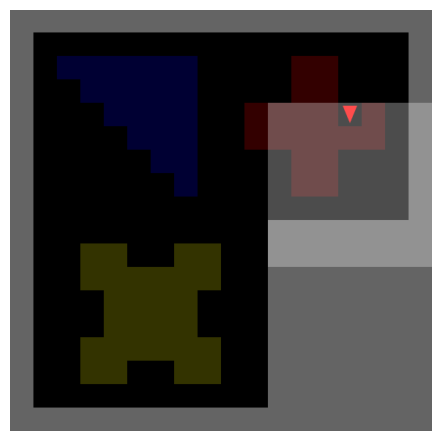

In [3]:
#Let's take a look at the environment
env.reset()
render = env.render()

plt.figure()
plt.subplot(1,1,1)
plt.imshow(render)
plt.tight_layout()
plt.axis('off')
plt.savefig("docs/_static/env_render.png", dpi = 300)
plt.show()


In [ ]:
#Make a pRNN
num_neurons = 500
pRNNtype = "Masked"

predictiveNet = PredictiveNet(env, hidden_size=num_neurons, pRNNtype=pRNNtype, k = 5, use_LN = True)

In [5]:
#specify an action policy (agent)
action_probability = np.array([0.15,0.15,0.6,0.1,0,0,0])
agent = RandomActionAgent(env.action_space, action_probability)


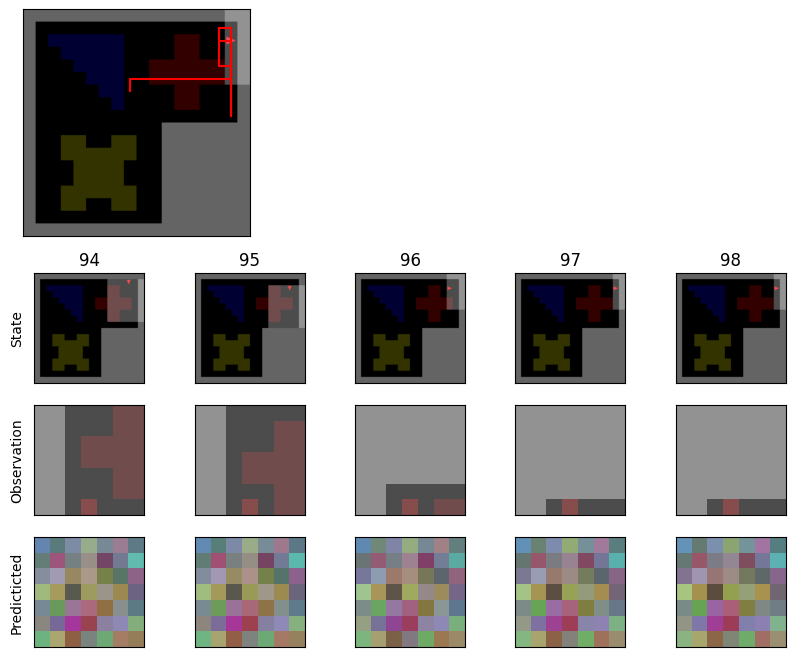

In [6]:
#run a sample trajectory (note: predictions will be garbage, agent is untrained)
predictiveNet.plotSampleTrajectory(env,agent, savename = "traj_pre", savefolder = "docs/_static")
plt.show()


In [7]:
#Run one training epoch of 500 trials, each 500 steps long
sequence_duration = 6 # (500) #minimum 6
num_trials = 6 #0 (50) #minimum 6 (why is this the case...)

predictiveNet.trainingEpoch(env, agent,
                            sequence_duration=sequence_duration,
                            num_trials=num_trials)

Training pRNN on cpu...
loss: 0.04, sparsity: 3.6e+01, meanrate: 0.39 [    0\    6]
loss: 0.031, sparsity: 3.8e+01, meanrate: 0.39 [    3\    6]
loss: 0.024, sparsity: 3.8e+01, meanrate: 0.39 [    5\    6]
Epoch Complete. Back to the cpu


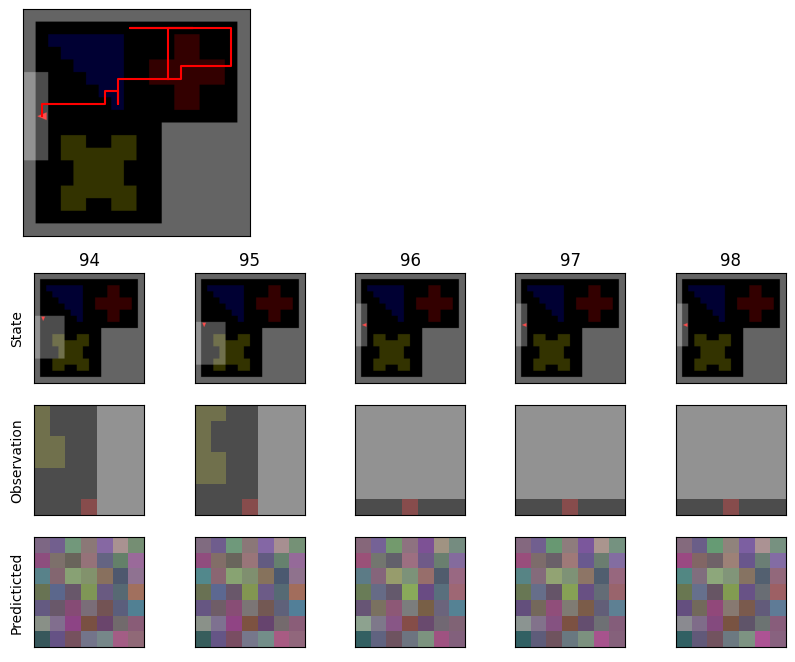

/gpfs/radev/project/levenstein/vv266/pRNN/prnn/utils/predictiveNet.py:441: DeprecationWarning: invalid escape sequence \{
  print(f"loss: {steploss:>.2}, sparsity: {sparsity:>.2}, meanrate: {meanrate:>.2} [{bb:>5d}\{num_trials:>5d}]")
/gpfs/radev/project/levenstein/vv266/pRNN/prnn/utils/predictiveNet.py:471: DeprecationWarning: invalid escape sequence \{
  print(f"loss: {steploss:>.2}, sparsity: {sparsity:>.2}, meanrate: {meanrate:>.2} [{bb:>5d}\{num_trials:>5d}]")


KeyboardInterrupt: 

In [8]:
#run a sample trajectory. did the predictions get better?
predictiveNet.plotSampleTrajectory(env,agent, savename = "traj_post", savefolder = "docs/_static")
plt.show()

#Let's take a look at the spatial position decoding and tuning curves 
place_fields, SI, decoder = predictiveNet.calculateSpatialRepresentation(env,agent,
                                                trainDecoder=True, saveTrainingData=True)

predictiveNet.calculateDecodingPerformance(env,agent,decoder)
predictiveNet.plotTuningCurvePanel()

In [8]:
obs, act, state, render = predictiveNet.collectObservationSequence(env,agent,10,discretize=True)
obs_pred, obs_next, h  = predictiveNet.predict(obs,act, fullRNNstate=False, batched=True)


/gpfs/radev/project/levenstein/vv266/pRNN/prnn/utils/predictiveNet.py:441: DeprecationWarning: invalid escape sequence \{
  print(f"loss: {steploss:>.2}, sparsity: {sparsity:>.2}, meanrate: {meanrate:>.2} [{bb:>5d}\{num_trials:>5d}]")
/gpfs/radev/project/levenstein/vv266/pRNN/prnn/utils/predictiveNet.py:471: DeprecationWarning: invalid escape sequence \{
  print(f"loss: {steploss:>.2}, sparsity: {sparsity:>.2}, meanrate: {meanrate:>.2} [{bb:>5d}\{num_trials:>5d}]")


RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 11 but got size 10 for tensor number 1 in the list.

In [7]:
print(h.shape)

torch.Size([1, 10, 500])


In [ ]:
predictiveNet.plotObservationSequence(obs, render, obs_pred, state)



In [ ]:
#Looks like we'll need to train some more. This will take a while... 
#Often we like to precompute a dataset of random trajectories to speed things up
#  - check out dataloader_example.ipynb for how to do this

#the script trainNet.py can be used to train a network for many epochs and save the results
#this can be called in a bash scipt to submit a job using e.g. 
# trainNet.py --savefolder='examplenet/' --lr=2e-3 --numepochs=50 --batchsize=16 --pRNNtype='thRNN_5win' --actenc='SpeedHD'
#You'll want to modify it or make your own, to fit the needs of your own project
#An example of how to call it, and submit on a GPU cluster is in trainNet_slurm.sh 